In [5]:
import pandas as pd
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, GRU
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset
from keras_tuner import RandomSearch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve


In [12]:
# # za 1 razem pobrac
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JanZemło(259194)\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JanZemło(259194)\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JanZemło(259194)\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\JanZemło(259194)\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [11]:
df = pd.read_csv('training.csv', header=None, names=['sentiment', 'id', 'date', 'query', 'user', 'text'], encoding='ISO-8859-1')
df = df.drop(columns=['query', 'id', 'user', 'date'])

C:\Users\JanZemło(259194)\AppData\Local\Temp\ipykernel_19148\1493389583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


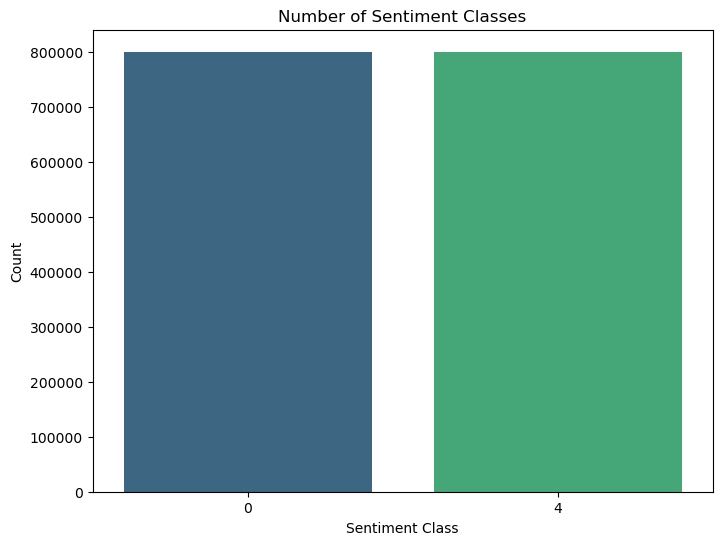

In [13]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Number of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [15]:
def count_hashtags(text):
    return len(re.findall(r'#', text))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove numbers (optional: uncomment if needed)
    # text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['hashtag_count'] = df['text'].apply(count_hashtags)

In [16]:
df['cleaned_text'] = df['text'].apply(clean_text)
df

,sentiment,text,hashtag_count,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,0,dived many time ball managed save 50 rest go b...
3,0,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",0,behaving im mad cant see
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,0,woke school best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,0,thewdbcom cool hear old walt interview â
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,0,ready mojo makeover ask detail
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,0,happy 38th birthday boo alll time tupac amaru ...


In [17]:
# Tokenizacja
num_words=10000
max_length = 20

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_binary = [1 if label == 4 else 0 for label in df['sentiment']]

In [18]:
# Podział na dane treningowe, walidacyjne i testowe
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_binary, test_size=0.3, stratify=y_binary, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

In [19]:
# Zbiory do wybory hiperparametrów
X_train_subset = X_train[::10]
y_train_subset = y_train[::10]
X_val_subset = X_val[::10]
y_val_subset = y_val[::10]

In [20]:
X_train_subset.shape

(112000, 20)

Trial 10 Complete [00h 03m 49s]
val_loss: 0.4477944076061249

Best val_loss So Far: 0.4394916594028473
Total elapsed time: 00h 36m 33s
Najlepsze hiperparametry:
Liczba jednostek LSTM: 32
Współczynnik dropout: 0.1
Liczba jednostek Dense: 48
Współczynnik uczenia: 0.0010624691555580386
Rozmiar batcha: 64


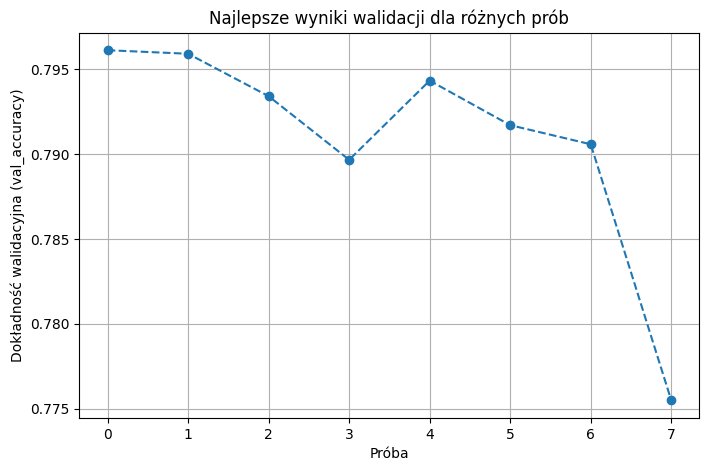

In [13]:

def build_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])
        ),
        LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
            return_sequences=False
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']    )
    return model

# Random Search
tuner_lstm = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_lstm_tuning',
    project_name='lstm_tuning_with_lr'
)

# Zatrzymanie uczenia przy braku poprawy
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True  
)

# Wykonywanie wyszukiwania z EarlyStopping
tuner_lstm.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val_subset, y_val_subset),
    epochs=10,
    batch_size=tuner_lstm.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]),
    callbacks=[early_stopping]
)

# Pobranie najlepszych hiperparametrów
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba jednostek LSTM: {best_hps_lstm.get('lstm_units')}")
print(f"Współczynnik dropout: {best_hps_lstm.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_lstm.get('dense_units')}")
print(f"Współczynnik uczenia: {best_hps_lstm.get('learning_rate')}")
print(f"Rozmiar batcha: {best_hps_lstm.get('batch_size')}")

# 5. Wizualizacja wyników
# Pobranie najlepszych prób
best_trials_lstm = tuner_lstm.oracle.get_best_trials(num_trials=10)
# Zbieranie wyników walidacyjnych tylko dla prób, które mają 'val_accuracy'
val_accuracies = [
    trial.metrics.metrics['val_accuracy'].get_history()[-1].value
    for trial in best_trials_lstm
    if 'val_accuracy' in trial.metrics.metrics and trial.metrics.metrics['val_accuracy'].get_history()
]

# Rysowanie wykresu tylko, jeśli mamy jakieś wyniki
if val_accuracies:
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies, marker='o', linestyle='--')
    plt.title('Najlepsze wyniki walidacji dla różnych prób')
    plt.xlabel('Próba')
    plt.ylabel('Dokładność walidacyjna (val_accuracy)')
    plt.grid(True)
    plt.show()
else:
    print("Brak wyników walidacyjnych do wizualizacji.")

Trial 10 Complete [00h 01m 18s]
val_loss: 0.46898168325424194

Best val_loss So Far: 0.4445075988769531
Total elapsed time: 00h 32m 03s
Najlepsze hiperparametry:
Liczba filtrów w Conv1D: 128
Rozmiar jądra (kernel_size): 5
Liczba jednostek Dense: 80
Współczynnik dropout: 0.2
Współczynnik uczenia: 0.0003021384939866327
Rozmiar batcha: 16


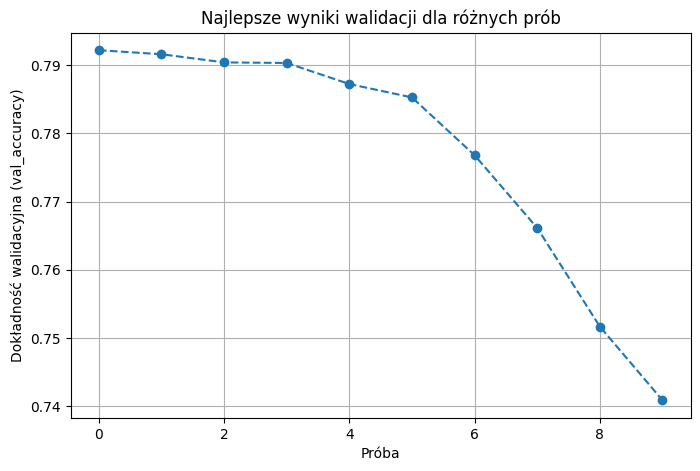

In [15]:
def build_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])
        ),
        Conv1D(
            filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32), 
            kernel_size=hp.Choice('kernel_size', [3, 5, 7]), 
            activation='relu'
        ),
        GlobalMaxPooling1D(),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC'] )
    return model

# Random Search
tuner_cnn = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,
    directory='random_search_cnn_tuning',
    project_name='cnn_tuning'
)

# EarlyStopping: zatrzymanie po braku poprawy

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,  
    restore_best_weights=True  
)

# Wyszukiwanie hiperparametrów
tuner_cnn.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=tuner_cnn.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]),
    callbacks=[early_stopping]
)

# Najlepsze hiperparametry
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba filtrów w Conv1D: {best_hps_cnn.get('conv_filters')}")
print(f"Rozmiar jądra (kernel_size): {best_hps_cnn.get('kernel_size')}")
print(f"Liczba jednostek Dense: {best_hps_cnn.get('dense_units')}")
print(f"Współczynnik dropout: {best_hps_cnn.get('dropout_rate')}")
print(f"Współczynnik uczenia: {best_hps_cnn.get('learning_rate')}")
print(f"Rozmiar batcha: {best_hps_cnn.get('batch_size')}")

best_trials_cnn = tuner_cnn.oracle.get_best_trials(num_trials=10)
# Zbieranie wyników walidacyjnych tylko dla prób, które mają 'val_accuracy'
val_accuracies_cnn = [
    trial.metrics.metrics['val_accuracy'].get_history()[-1].value
    for trial in best_trials_cnn
    if 'val_accuracy' in trial.metrics.metrics and trial.metrics.metrics['val_accuracy'].get_history()
]

# Rysowanie wykresu tylko, jeśli mamy jakieś wyniki
if val_accuracies_cnn:
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies_cnn, marker='o', linestyle='--')
    plt.title('Najlepsze wyniki walidacji dla różnych prób')
    plt.xlabel('Próba')
    plt.ylabel('Dokładność walidacyjna (val_accuracy)')
    plt.grid(True)
    plt.show()
else:
    print("Brak wyników walidacyjnych do wizualizacji.")

Trial 10 Complete [00h 02m 50s]
val_loss: 0.49856212735176086

Best val_loss So Far: 0.440349817276001
Total elapsed time: 00h 42m 48s
Najlepsze hiperparametry:
Liczba jednostek GRU: 96
Współczynnik dropout: 0.1
Liczba jednostek Dense: 32
Współczynnik uczenia: 0.000381041931665807
Rozmiar batcha: 64


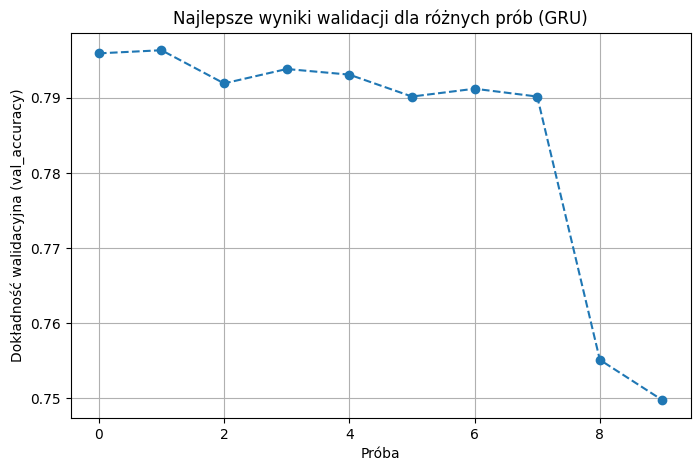

In [17]:
def build_gru_model(hp):
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])
        ),
        GRU(
            units=hp.Int('gru_units', min_value=32, max_value=128, step=32), 
            return_sequences=False
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC'])
    return model

# Random Search
tuner_gru = RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search_gru_tuning',
    project_name='gru_tuning_with_lr'
)

# Zatrzymanie uczenia przy braku poprawy
early_stopping_gru = EarlyStopping(
    monitor='val_loss', 
    patience=3,          
    restore_best_weights=True  
)

# Wykonywanie wyszukiwania z EarlyStopping
tuner_gru.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val_subset, y_val_subset),
    epochs=10,
    batch_size=tuner_gru.oracle.hyperparameters.Choice('batch_size', [16, 32, 64]),
    callbacks=[early_stopping_gru]
)

# Pobranie najlepszych hiperparametrów
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba jednostek GRU: {best_hps_gru.get('gru_units')}")
print(f"Współczynnik dropout: {best_hps_gru.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_gru.get('dense_units')}")
print(f"Współczynnik uczenia: {best_hps_gru.get('learning_rate')}")
print(f"Rozmiar batcha: {best_hps_gru.get('batch_size')}")

# Wizualizacja wyników
best_trials_gru = tuner_gru.oracle.get_best_trials(num_trials=10)
val_accuracies_gru = [
    trial.metrics.metrics['val_accuracy'].get_history()[-1].value
    for trial in best_trials_gru
    if 'val_accuracy' in trial.metrics.metrics and trial.metrics.metrics['val_accuracy'].get_history()
]

if val_accuracies_gru:
    plt.figure(figsize=(8, 5))
    plt.plot(val_accuracies_gru, marker='o', linestyle='--')
    plt.title('Najlepsze wyniki walidacji dla różnych prób (GRU)')
    plt.xlabel('Próba')
    plt.ylabel('Dokładność walidacyjna (val_accuracy)')
    plt.grid(True)
    plt.show()
else:
    print("Brak wyników walidacyjnych do wizualizacji.")


In [18]:
best_model_lstm = tuner_lstm.hypermodel.build(best_hps_lstm)
history_lstm = best_model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps_lstm.get('batch_size')
)

# Ewaluacja
results_lstm = best_model_lstm.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results_lstm)

# Zapis najlepszego modelu
best_model_lstm.save("models/best_lstm_sentiment_model.h5")

Epoch 1/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - AUC: 0.8631 - accuracy: 0.7815 - loss: 0.4576 - val_AUC: 0.8975 - val_accuracy: 0.8149 - val_loss: 0.4060
Epoch 2/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - AUC: 0.9050 - accuracy: 0.8228 - loss: 0.3898 - val_AUC: 0.9019 - val_accuracy: 0.8200 - val_loss: 0.3957
Epoch 3/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - AUC: 0.9143 - accuracy: 0.8328 - loss: 0.3711 - val_AUC: 0.9029 - val_accuracy: 0.8212 - val_loss: 0.3941
Epoch 4/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - AUC: 0.9214 - accuracy: 0.8410 - loss: 0.3561 - val_AUC: 0.9019 - val_accuracy: 0.8206 - val_loss: 0.3984
Epoch 5/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - AUC: 0.9287 - accuracy: 0.8490 - loss: 0.3396 - val_AUC: 0.9003 - val_accuracy: 0.8191 - val_loss: 0.4068
Epoch 6/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - AUC: 0.9346 - accuracy: 0.8571 - loss: 0.3258 - val_AUC: 0.8976 - val_accuracy: 0.8172 - val_loss: 0.4124
Epoch 7/10

Final Loss, Accuracy: [0.46993401646614075, 0.8105124831199646, 0.8879654407501221]


In [20]:
# Trening najlepszego modelu CNN
best_model_cnn = tuner_cnn.hypermodel.build(best_hps_cnn)
history_cnn = best_model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps_cnn.get('batch_size')
)

# Ewaluacja modelu CNN
results_cnn = best_model_cnn.evaluate(X_val, y_val)
print("Final Loss, Accuracy for CNN:", results_cnn)

# Zapis najlepszego modelu CNN
best_model_cnn.save("models/best_cnn_sentiment_model.h5")


Epoch 1/10
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 614s 9ms/step - AUC: 0.8641 - accuracy: 0.7816 - loss: 0.4562 - val_AUC: 0.8970 - val_accuracy: 0.8148 - val_loss: 0.4054
Epoch 2/10
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 512s 7ms/step - AUC: 0.9040 - accuracy: 0.8220 - loss: 0.3918 - val_AUC: 0.9000 - val_accuracy: 0.8172 - val_loss: 0.4010
Epoch 3/10
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 488s 7ms/step - AUC: 0.9159 - accuracy: 0.8355 - loss: 0.3681 - val_AUC: 0.9007 - val_accuracy: 0.8182 - val_loss: 0.3995
Epoch 4/10
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 490s 7ms/step - AUC: 0.9262 - accuracy: 0.8475 - loss: 0.3457 - val_AUC: 0.8993 - val_accuracy: 0.8178 - val_loss: 0.4023
Epoch 5/10
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 492s 7ms/step - AUC: 0.9338 - accuracy: 0.8565 - loss: 0.3278 - val_AUC: 0.8972 - val_accuracy: 0.8150 - val_loss: 0.4100
Epoch 6/10
70000/70000 ━━━━━━━━━━━━━━━━━━━━ 494s 7ms/step - AUC: 0.9419 - accuracy: 0.8675 - loss: 0.3078 - val_AUC: 0.8947 - val_accuracy: 0.8139 - val_loss: 0.4169
Epoc

Final Loss, Accuracy for CNN: [0.474547415971756, 0.8010083436965942, 0.8790205121040344]


In [21]:
# Trening najlepszego modelu GRU
best_model_gru = tuner_gru.hypermodel.build(best_hps_gru)
history_gru = best_model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps_gru.get('batch_size')
)

# Ewaluacja modelu GRU
results_gru = best_model_gru.evaluate(X_val, y_val)
print("Final Loss, Accuracy for GRU:", results_gru)

# Zapis najlepszego modelu GRU
best_model_gru.save("models/best_gru_sentiment_model.h5")


Epoch 1/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 208s 12ms/step - AUC: 0.8559 - accuracy: 0.7728 - loss: 0.4634 - val_AUC: 0.8974 - val_accuracy: 0.8145 - val_loss: 0.4051
Epoch 2/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 230s 13ms/step - AUC: 0.9044 - accuracy: 0.8222 - loss: 0.3907 - val_AUC: 0.9028 - val_accuracy: 0.8202 - val_loss: 0.3938
Epoch 3/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 230s 13ms/step - AUC: 0.9152 - accuracy: 0.8341 - loss: 0.3693 - val_AUC: 0.9044 - val_accuracy: 0.8217 - val_loss: 0.3931
Epoch 4/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 231s 13ms/step - AUC: 0.9230 - accuracy: 0.8427 - loss: 0.3526 - val_AUC: 0.9045 - val_accuracy: 0.8230 - val_loss: 0.3925
Epoch 5/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 232s 13ms/step - AUC: 0.9308 - accuracy: 0.8522 - loss: 0.3350 - val_AUC: 0.9022 - val_accuracy: 0.8210 - val_loss: 0.3981
Epoch 6/10
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 232s 13ms/step - AUC: 0.9391 - accuracy: 0.8630 - loss: 0.3150 - val_AUC: 0.8991 - val_accuracy: 0.8192 - val_loss: 0.411

Final Loss, Accuracy for GRU: [0.5032882690429688, 0.8067749738693237, 0.879001796245575]


In [26]:
from keras.metrics import get
print(get.__globals__.keys())

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'inspect', 'keras_export', 'metric', 'reduction_metrics', 'accuracy_metrics', 'Accuracy', 'BinaryAccuracy', 'CategoricalAccuracy', 'SparseCategoricalAccuracy', 'SparseTopKCategoricalAccuracy', 'TopKCategoricalAccuracy', 'metrics_utils', 'confusion_metrics', 'AUC', 'FalseNegatives', 'FalsePositives', 'Precision', 'PrecisionAtRecall', 'Recall', 'RecallAtPrecision', 'SensitivityAtSpecificity', 'SpecificityAtSensitivity', 'TrueNegatives', 'TruePositives', 'f_score_metrics', 'F1Score', 'FBetaScore', 'hinge_metrics', 'CategoricalHinge', 'Hinge', 'SquaredHinge', 'iou_metrics', 'BinaryIoU', 'IoU', 'MeanIoU', 'OneHotIoU', 'OneHotMeanIoU', 'Metric', 'probabilistic_metrics', 'BinaryCrossentropy', 'CategoricalCrossentropy', 'KLDivergence', 'Poisson', 'SparseCategoricalCrossentropy', 'Mean', 'MeanMetricWrapper', 'Sum', 'regression_metrics', 'CosineSimilarity', 'LogCoshErr

In [6]:
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


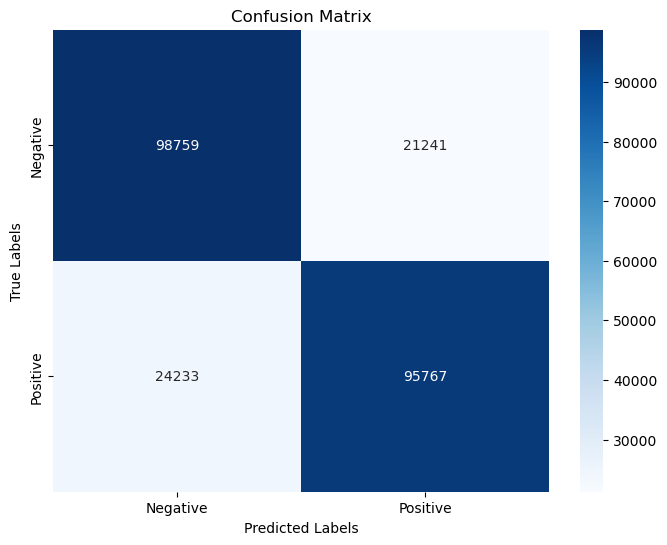

Test F1 Score: 0.808133058799703
Test Precision: 0.8184654040749351
Test Recall: 0.7980583333333333
Test Accuracy: 0.810525
Test ROC AUC: 0.8884215382638889


In [24]:
# Load the model and prepare the test data
best_model_LSTM_evaluation = load_model('models/best_lstm_sentiment_model.h5')
test_preds = best_model_LSTM_evaluation.predict(X_test)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test, test_preds_binary)
test_precision = precision_score(y_test, test_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds)

# Oblicz macierz konfuzji
conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Wizualizacja macierzy
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)



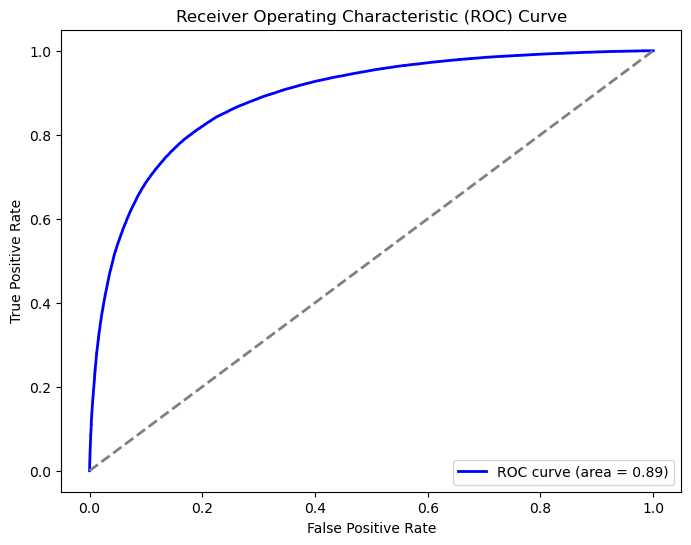

In [26]:
# Oblicz wartości dla krzywej ROC
fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

# Wizualizacja krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 7s 937us/step


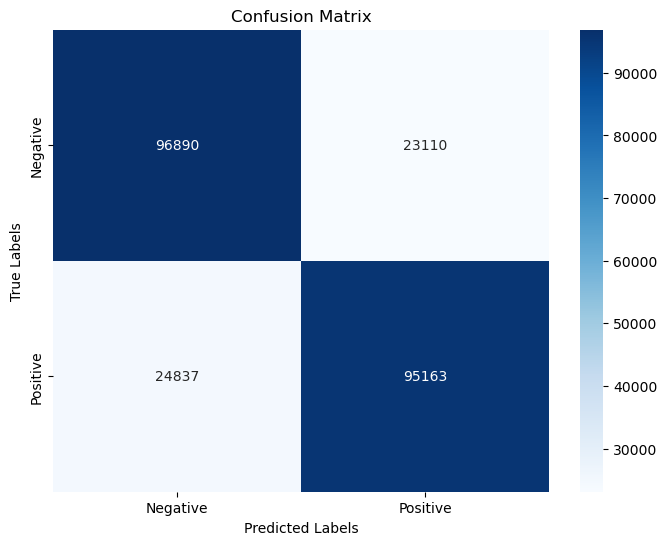

Test F1 Score: 0.7987728362004927
Test Precision: 0.8046046012192132
Test Recall: 0.793025
Test Accuracy: 0.8002208333333334
Test ROC AUC: 0.8784887068055556


In [27]:
# Load the model and prepare the test data
best_model_CNN_evaluation = load_model('models/best_cnn_sentiment_model.h5')
test_preds = best_model_CNN_evaluation.predict(X_test)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test, test_preds_binary)
test_precision = precision_score(y_test, test_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds)

# Oblicz macierz konfuzji
conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Wizualizacja macierzy
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

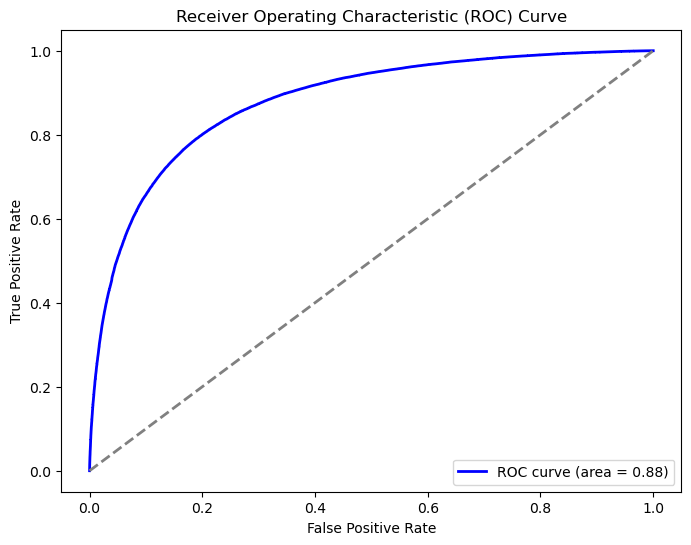

In [28]:
# Oblicz wartości dla krzywej ROC
fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

# Wizualizacja krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


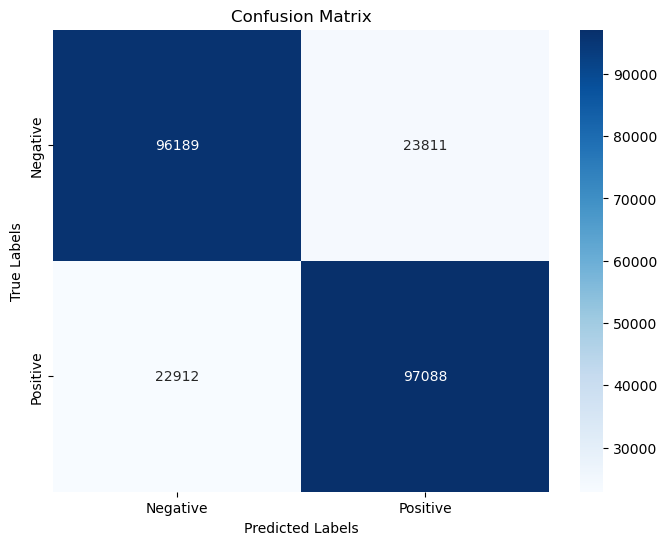

Test F1 Score: 0.8060473476436183
Test Precision: 0.8030504801528549
Test Recall: 0.8090666666666667
Test Accuracy: 0.8053208333333334
Test ROC AUC: 0.8791459540277777


In [29]:
# Load the model and prepare the test data
best_model_GRU_evaluation = load_model('models/best_gru_sentiment_model.h5')
test_preds = best_model_GRU_evaluation.predict(X_test)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test, test_preds_binary)
test_precision = precision_score(y_test, test_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds)

# Oblicz macierz konfuzji
conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Wizualizacja macierzy
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

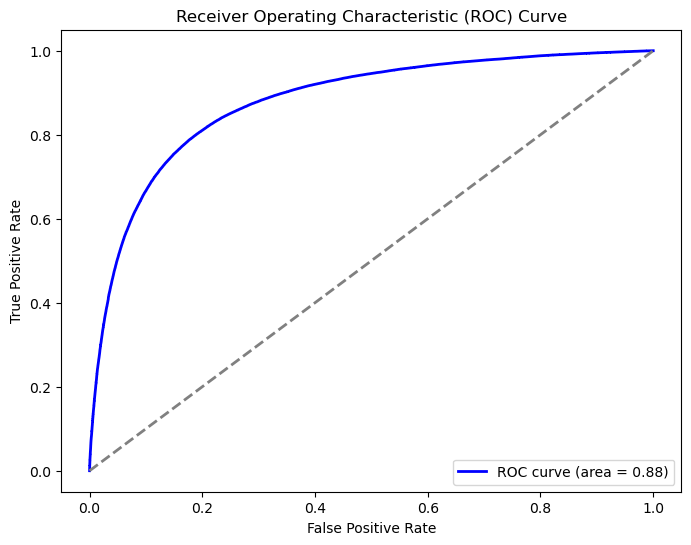

In [30]:
# Oblicz wartości dla krzywej ROC
fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

# Wizualizacja krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()